In [1]:
import mne
import mne.io

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline

In [3]:
data_path = "/home/pfilipia/inria/chu_nice_inria/patients_ecog"
patient_path_prefix = data_path + "/patient10/20190408_1248"

events_data = pd.read_csv(
    "%s_events.csv" % patient_path_prefix, header=0
)

raw = mne.io.read_raw_brainvision(
    vhdr_fname="%s_brainvision.vhdr" % patient_path_prefix, montage=None
)

Extracting parameters from /home/pfilipia/inria/chu_nice_inria/patients_ecog/patient10/20190408_1248_brainvision.vhdr...
Setting channel info structure...


<ipython-input-3-78f701a5895f>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  vhdr_fname="%s_brainvision.vhdr" % patient_path_prefix, montage=None


In [4]:
raw.load_data()
raw.filter(l_freq=0.5, h_freq=1000)
# raw.filter(l_freq=0.5, h_freq=30)
raw.notch_filter(freqs=50, notch_widths=9)


Reading 0 ... 1302114  =      0.000 ...   635.798 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 24.00 Hz (-6 dB cutoff frequency: 1012.00 Hz)
- Filter length: 13517 samples (6.600 sec)

Setting up band-stop filter from 45 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 45.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 44.

<RawBrainVision  |  20190408_1248_brainvision.eeg, n_channels x n_times : 14 x 1302115 (635.8 sec), ~139.1 MB, data loaded>

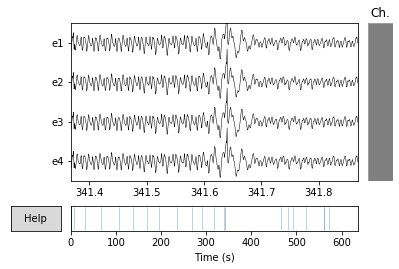

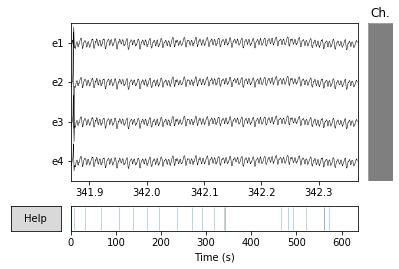

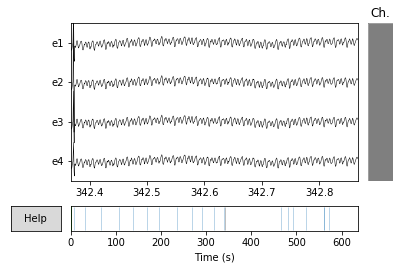

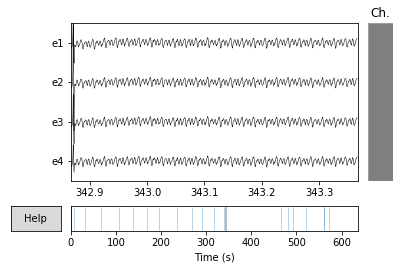

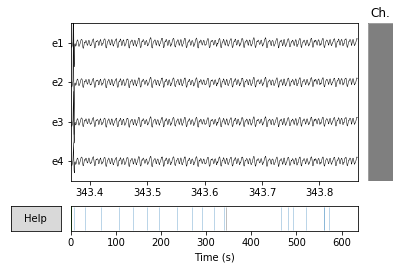

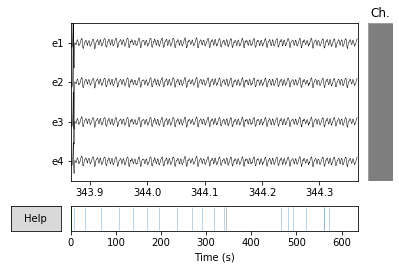

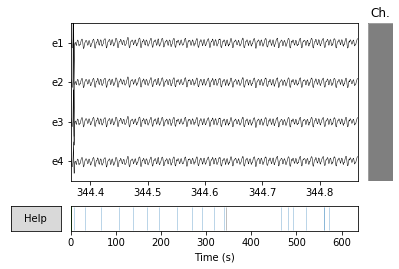

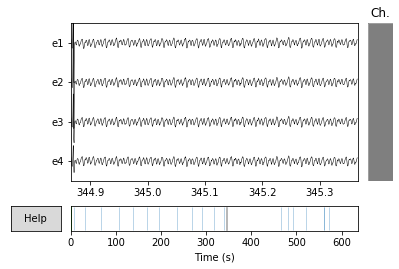

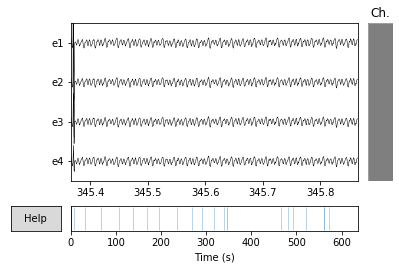

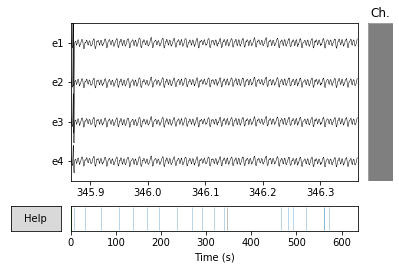

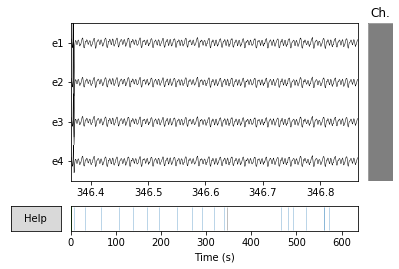

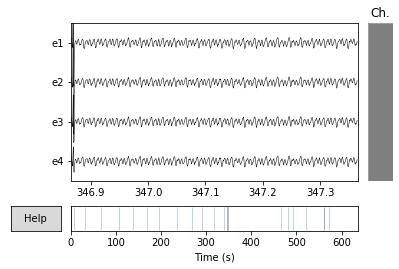

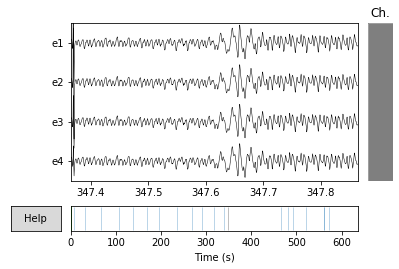

OK


In [5]:
stim_id = 0

# events_range = np.arange(
#     events_data.loc[stim_id]['time_begin'],
#     events_data.loc[stim_id]['time_end'],
#     events_data.loc[stim_id]['time_interval']
# )

events_range = np.arange(
    341.368, 347.6,
    0.49975
)

for t_start in events_range:
    raw.plot(start=t_start, duration=0.4999, order=[0, 1, 2, 3], n_channels=4, scalings={'eeg': 0.01})
#     raw.plot(start=t_start, duration=0.4999, n_channels=14, scalings={'eeg': 0.001})
#     raw_common_avg.plot(start=t_start, duration=0.4999, n_channels=1, scalings={'eeg': 0.001})

print("OK")

In [8]:
from scipy import stats

z_score_threshold = 5

for event_record in events_data.iterrows():

    events_range = np.arange(
        event_record[1]['time_begin'] + event_record[1]['time_interval'],
        event_record[1]['time_end'],
        event_record[1]['time_interval']
    )

    artifact_onsets = []
    for t_start in events_range:

        raw_data = raw.copy().crop(tmin=t_start, tmax=t_start + event_record[1]['time_interval']).get_data()
        z_score_data = stats.zscore(np.max(np.abs(raw_data), axis=0))

        artifact_onsets.append(np.argmax(z_score_data > z_score_threshold))

    print(
        np.round(np.min(artifact_onsets)), 
        np.round(np.max(artifact_onsets)),
        np.round(
            event_record[1]['time_begin'] + (np.mean(artifact_onsets)) / raw.info['sfreq'], 3
        )
    )

4 5 7.547
7 8 29.536
8 9 106.995
10 11 139.478
7 8 170.962
9 10 195.449
7 8 235.428
10 10 269.41
10 11 291.398
10 10 318.884


In [7]:
t_event_1_beg = events_data.loc[stim_id]['time_begin'] + events_data.loc[stim_id]['time_interval']
t_event_1_end = events_data.loc[stim_id]['time_end'] - events_data.loc[stim_id]['time_interval']
t_interval = events_data.loc[stim_id]['time_interval']

events = np.empty((0, 3), dtype=int)

reject_epochs = [2, 4, 6, 8, 10]
cur_epoch = 0

for t_start in np.arange(t_event_1_beg, t_event_1_end, t_interval):
    
    cur_epoch = cur_epoch + 1
    if cur_epoch in reject_epochs:
        continue
        
    events = np.vstack([
        events, 
        np.array([raw.time_as_index(t_start), 0, 1], dtype=int)
    ])

event_id = dict(stimulation=1)

t_min = 0
t_max = events_data.loc[stim_id]['time_interval']

epochs = mne.Epochs(raw, events, event_id, t_min, t_max, baseline=(events_data.loc[stim_id]['time_interval'] - 0.005, events_data.loc[stim_id]['time_interval']))

6 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 6 events and 1024 original time points ...
0 bad epochs dropped
Loading data for 6 events and 1024 original time points ...
Loading data for 6 events and 1024 original time points ...


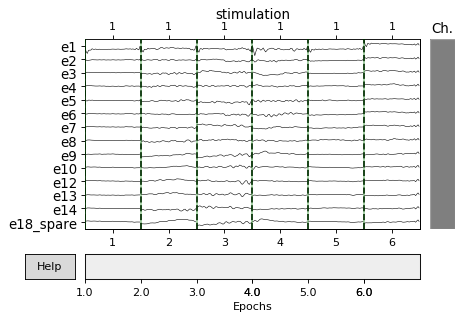

OK


In [20]:
epochs.get_data()
epochs.plot(n_channels=14, scalings={'eeg': 0.001})

print("OK")

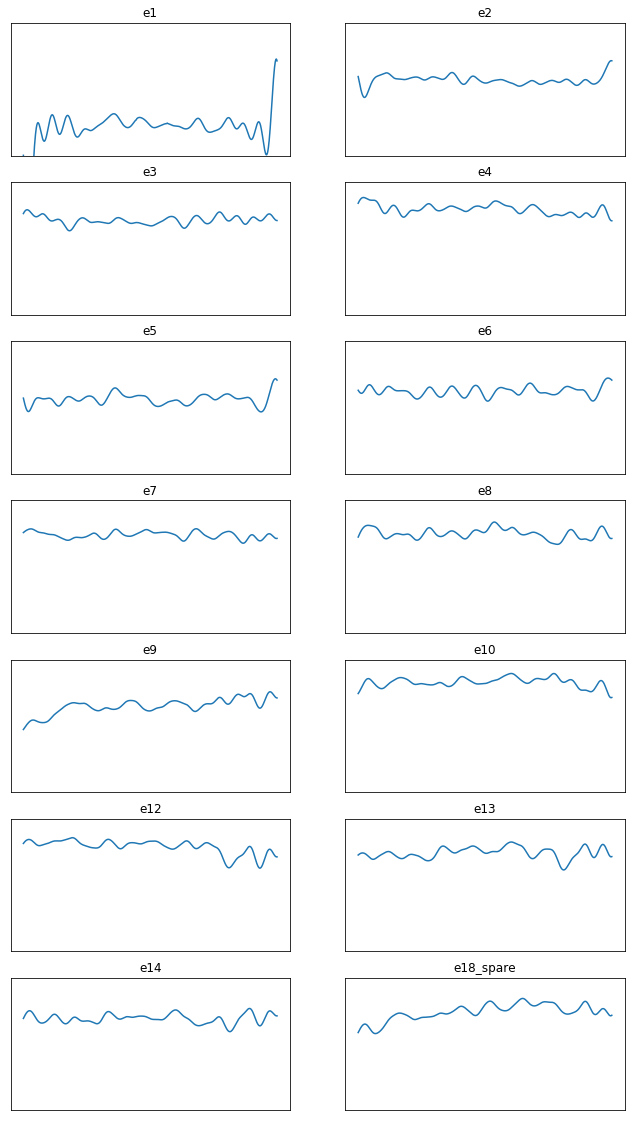

In [21]:
plt.figure(figsize=(11,20))

for i in range(14):
    avg_data = epochs.average(picks=[i]).crop(tmin=0.01).data
    avg_channel_name = epochs.average(picks=[i]).crop(tmin=0.01).ch_names[0]
    plt.subplot(7, 2, i+1)
    plt.plot(avg_data.T)
    plt.ylim([-0.0005, 0.0002])
    plt.xticks([])
    plt.yticks([])
    plt.title(avg_channel_name)
    
plt.savefig("stim_s%d.png" % stim_id)


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-22-23a8dd4419c4>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs.average(picks=[4]).crop(tmin=0.01).plot()


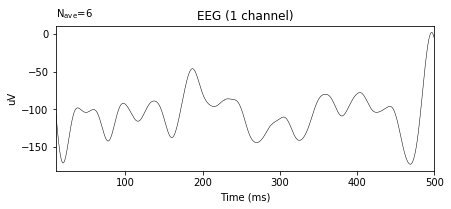

In [22]:
epochs.average(picks=[4]).crop(tmin=0.01).plot()
None